In [2]:
from driver.common.cmd_util import (
    common_arg_parser,
    parse_unknown_args
)
import sys
from run import configure_logger, parse_cmdline_kwargs
# pretend these were typed on the command line
#TEST-DNNEVO-2.swf
argv = """
  --env ThreeSizeAppEnv-v1 --policy MlpLstmPolicy --algo RecurrentPPO --num_timesteps 2_000 --pretraining_timesteps 2_000 --tensorboard_log '.' --workload_file TEST-DNNEVO-2.swf
""".split()
arg_parser = common_arg_parser()
args, unknown_args = arg_parser.parse_known_args(argv)
configure_logger(args.log_path, format_strs=['stdout', 'log', 'csv'])
extra_args = parse_cmdline_kwargs(unknown_args)
#extra_args['use_random_wrapper']=True
from run import build_env
#args.observation_history_length = 8
args.queue_wait_penalty=0.0005
args.initial_vm_count=1
args.mips_per_core=4400
env = build_env(args, extra_args)

format_strs: ['stdout', 'log', 'csv']
2025-10-25 13:39:04,169012: Logging to C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-10-25-13-39-04-165015\2025-10-25.1 in formats [<HumanOutputFormat(stdout)>, <HumanOutputFormat(C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-10-25-13-39-04-165015\2025-10-25.1\log.txt)>, <driver.logger.CSVOutputFormat object at 0x000002C47B054908>]
2025-10-25 13:39:04,171015: Loading workload from file: TEST-DNNEVO-2.swf
2025-10-25 13:39:04,175011: Dumping jobs available for training
2025-10-25 13:39:04,177015: {'jobId': 1, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-10-25 13:39:04,179014: {'jobId': 2, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-10-25 13:39:04,181016: {'jobId': 3, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-10-25 13:39:04,183014: {'jobId': 4, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-10-25 13:39:04,185014: {'jobId': 5, 'submissionDelay': 3600, 'mi': 3960000,

In [2]:
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
#model = PPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\MLP\ppo_MlpPolicy_mlp_baseline.zip')
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\SPCA\pca_MlpLstmPolicy_spca_recurrent.zip', env=env)
model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\BASELINE\arch_256\recurrentppo_MlpLstmPolicy_mlplstm_full_model_256.zip', env=env)
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\BASELINE\arch_256\ppo_mlp_intermediate_00_100000.zip', env=env)
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\BASELINE\arch_256_10_000\recurrentppo_MlpLstmPolicy_mlplstm_10_000.zip', env=env)

### Claude simplified Offline flow

In [3]:
import numpy as np
import gym
from stable_baselines3 import PPO
from sklearn.decomposition import SparsePCA
from collections import defaultdict

# def collect_observations(model, env, n_episodes=100):
#     """
#     Collect observations from trained PPO model.
    
#     Args:
#         model: Trained SB3 PPO model
#         env: Gym environment
#         n_episodes: Number of episodes to collect
    
#     Returns:
#         np.array: All observations collected (n_timesteps, n_features)
#     """
#     all_observations = []
    
#     for episode in range(n_episodes):
#         obs = env.reset()
#         done = False
#         episode_obs = []
        
#         while not done:
#             episode_obs.append(obs)
            
#             # Get action from trained policy
#             action, _states = model.predict(obs, deterministic=True)
#             obs, reward, done, info = env.step(action)
        
#         all_observations.extend(episode_obs)
        
#         if (episode + 1) % 10 == 0:
#             print(f"Collected {episode + 1}/{n_episodes} episodes, "
#                   f"total timesteps: {len(all_observations)}")
    
#     return np.array(all_observations)


def analyze_spca_loadings(spca_model, feature_names=None, n_features=7):
    """
    Analyze SPCA loadings to identify important features.
    
    Args:
        spca_model: Fitted SparsePCA model
        feature_names: List of feature names (optional)
        n_features: Number of original features
    
    Returns:
        dict: Feature importance scores and rankings
    """
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(n_features)]
    
    # Get absolute loadings across all components
    loadings = np.abs(spca_model.components_)  # Shape: (n_components, n_features)
    
    print("\n=== SPCA Component Loadings ===")
    for i, component in enumerate(loadings):
        print(f"\nComponent {i}:")
        for j, loading in enumerate(component):
            if loading > 0:  # Only show non-zero loadings
                print(f"  {feature_names[j]}: {loading:.4f}")
    
    # Calculate feature importance: sum of absolute loadings across components
    feature_importance = np.sum(loadings, axis=0)
    
    # Rank features
    feature_ranking = np.argsort(feature_importance)[::-1]
    
    print("\n=== Feature Importance Ranking ===")
    for rank, idx in enumerate(feature_ranking):
        print(f"{rank + 1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")
    
    return {
        'importance_scores': feature_importance,
        'feature_ranking': feature_ranking,
        'loadings': loadings
    }


def select_top_features(spca_model, n_features_to_select=4, 
                       feature_names=None, method='importance'):
    """
    Select top features based on SPCA analysis.
    
    Args:
        spca_model: Fitted SparsePCA model
        n_features_to_select: Number of features to select (3 or 4)
        feature_names: List of feature names (optional)
        method: 'importance' (sum of loadings) or 'nonzero' (non-zero in components)
    
    Returns:
        list: Indices of selected features
    """
    loadings = np.abs(spca_model.components_)
    
    if method == 'importance':
        # Select based on total importance across components
        feature_importance = np.sum(loadings, axis=0)
        top_features = np.argsort(feature_importance)[::-1][:n_features_to_select]
    
    elif method == 'nonzero':
        # Select features that have non-zero loadings in most components
        nonzero_counts = np.sum(loadings > 0, axis=0)
        top_features = np.argsort(nonzero_counts)[::-1][:n_features_to_select]
    
    else:
        raise ValueError("method must be 'importance' or 'nonzero'")
    
    print(f"\n=== Selected Top {n_features_to_select} Features ===")
    if feature_names is not None:
        for idx in top_features:
            print(f"  Feature {idx}: {feature_names[idx]}")
    else:
        print(f"  Feature indices: {top_features}")
    
    return top_features.tolist()


def main(env, model):
    """
    Complete pipeline: collect observations, apply SPCA, select features.
    """
    # ============================
    # 1. Load your trained model and environment
    # ============================
    
    
    from utils import FEATURE_NAMES
    feature_names = FEATURE_NAMES
    
    # ============================
    # 2. Collect observations
    # ============================
    print("Collecting observations from trained policy...")
    observations = collect_observations(model, env, n_episodes=100)
    observations = observations.squeeze(axis=1)
    print(f"\nCollected {observations.shape[0]} observations")
    print(f"Observation shape: {observations.shape}")
    
    # ============================
    # 3. Apply SPCA
    # ============================
    print("\nApplying Sparse PCA...")
    
    # Try different n_components (typically 3-4 for your use case)
    n_components = 5
    spca = SparsePCA(
        n_components=n_components,
        alpha=1.0,  # Sparsity parameter (higher = more sparse)
        ridge_alpha=0.01,
        max_iter=100,
        random_state=42
    )
    
    spca.fit(observations)
    print(f"SPCA fitted with {n_components} components")
    
    # ============================
    # 4. Analyze loadings
    # ============================
    results = analyze_spca_loadings(spca, feature_names=feature_names)
    
    # ============================
    # 5. Select top features
    # ============================
    n_features_to_select = 3  # or 3
    selected_features = select_top_features(
        spca, 
        n_features_to_select=n_features_to_select,
        feature_names=feature_names,
        method='importance'
    )
    
    # ============================
    # 6. Save results
    # ============================
    np.save('selected_features.npy', np.array(selected_features))
    print(f"\nSelected features saved to 'selected_features.npy'")
    print(f"Selected feature indices: {selected_features}")
    
    # ============================
    # 7. Optional: Test different sparsity parameters
    # ============================
    print("\n=== Testing Different Sparsity Parameters ===")
    for alpha in [0.1, 0.5, 1.0, 2.0]:
        print(f"\nAlpha = {alpha}")
        spca_test = SparsePCA(n_components=n_components, alpha=alpha, 
                             ridge_alpha=0.01, random_state=42)
        spca_test.fit(observations)
        
        # Count non-zero loadings
        nonzero_per_component = np.sum(np.abs(spca_test.components_) > 1e-4, axis=1)
        print(f"  Non-zero features per component: {nonzero_per_component}")
    
    env.close()
    return selected_features, spca, feature_names

#selected_features, spca, feature_names = main(env, model)


In [4]:
from utils import evaluate
mean_return, raw_obs_trace, ep_returns, actions = evaluate(model, env, n_episodes=100)
observations = raw_obs_trace
predictions = actions

Observations shape: (2500, 7)

STEP 1: Applying Elbow Method to Choose Number of Components
Testing different numbers of components...
  Testing 1 components...


    Reconstruction Error: 0.0707
    Explained Variance Ratio: -0.3145
    Avg non-zero features/component: 4.0
  Testing 2 components...
    Reconstruction Error: 0.0580
    Explained Variance Ratio: -0.0788
    Avg non-zero features/component: 3.5
  Testing 3 components...
    Reconstruction Error: 0.0514
    Explained Variance Ratio: 0.0436
    Avg non-zero features/component: 2.3
  Testing 4 components...
    Reconstruction Error: 0.0467
    Explained Variance Ratio: 0.1319
    Avg non-zero features/component: 1.8
  Testing 5 components...
    Reconstruction Error: 0.0448
    Explained Variance Ratio: 0.1671
    Avg non-zero features/component: 1.0
  Testing 6 components...
    Reconstruction Error: 0.0446
    Explained Variance Ratio: 0.1694
    Avg non-zero features/component: 1.0
  Testing 7 components...
    Reconstruction Error: 0.0446
    Explained Variance Ratio: 0.1694
    Avg non-zero features/component: 0.9


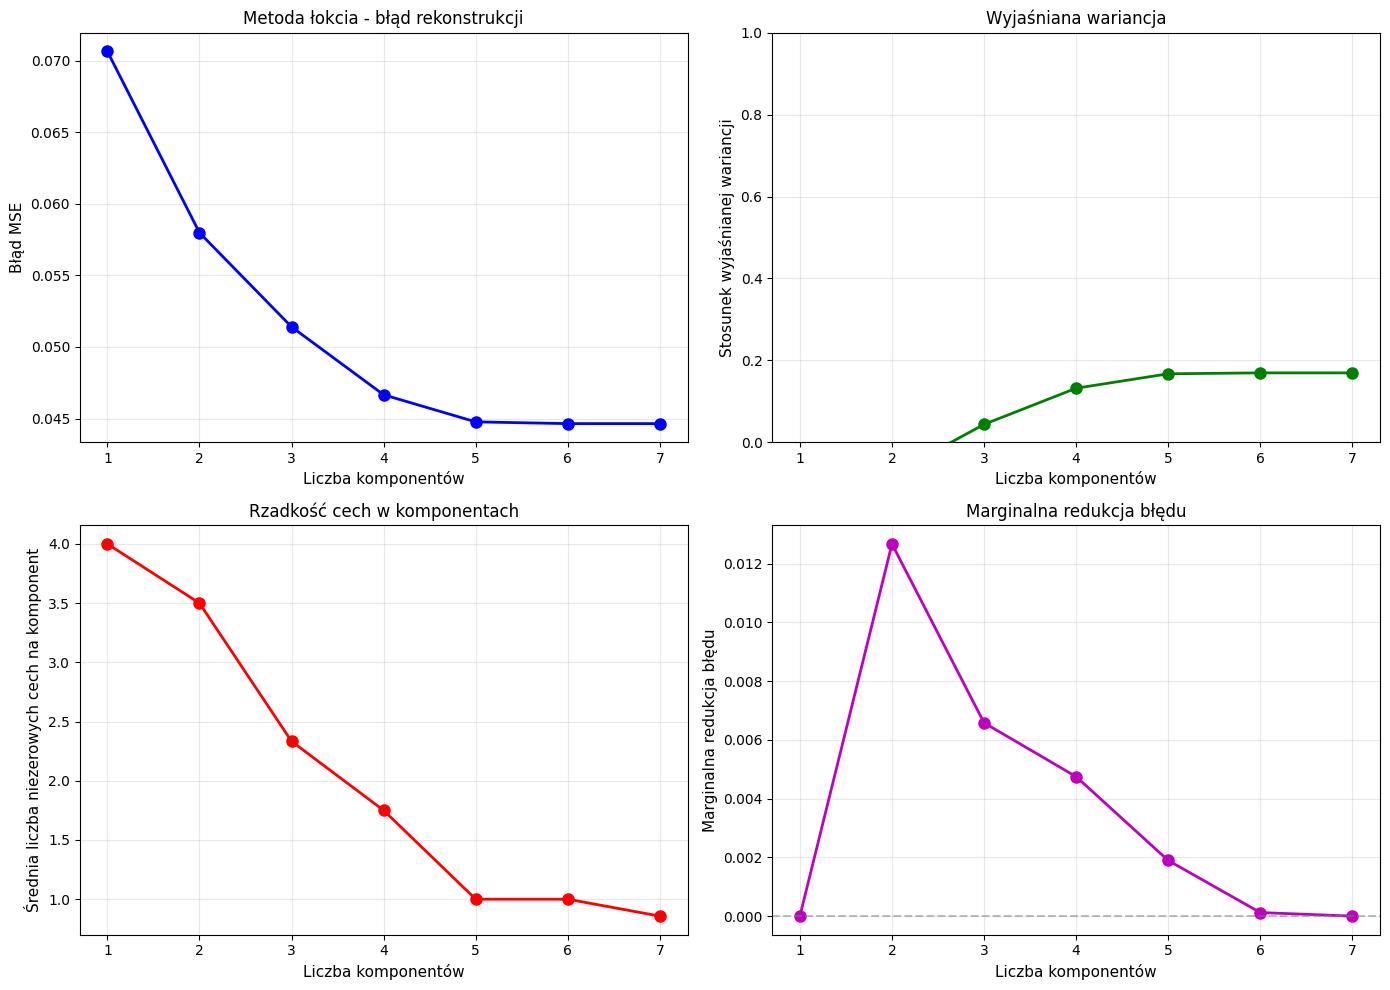


=== Summary ===
N_Comp   Recon_Error     Expl_Var_Ratio     Avg_NonZero    
------------------------------------------------------------
1        0.0707          -0.3145            4.0            
2        0.0580          -0.0788            3.5            
3        0.0514          0.0436             2.3            
4        0.0467          0.1319             1.8            
5        0.0448          0.1671             1.0            
6        0.0446          0.1694             1.0            
7        0.0446          0.1694             0.9            

=== Knee Detection ===
Suggested optimal number of components: 4

Proceeding with 4 components

Fitting final SPCA with 4 components...

=== SPCA Component Loadings ===

Component 0:
  avgCPUUtilization: 0.9586
  waitingJobsRatioGlobal: 0.2494
  waitingJobsRatioRecent: 0.1371

Component 1:
  waitingJobsRatioGlobal: 0.8336
  waitingJobsRatioRecent: 0.5523

Component 2:
  vmAllocatedRatio: 1.0000

Component 3:
  p90CPUUtilization: 1.0000



In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import SparsePCA

def elbow_method_spca(observations, max_components=7, alpha=1.0, feature_names=None):
    """
    Apply elbow method to determine optimal number of SPCA components.
    
    Args:
        observations: Data array (n_samples, n_features)
        max_components: Maximum number of components to test
        alpha: Sparsity parameter for SPCA
        feature_names: List of feature names (optional)
    
    Returns:
        dict: Results with explained variance and reconstruction error
    """
    n_features = observations.shape[1]
    max_components = min(max_components, n_features)
    
    explained_variance_ratios = []
    reconstruction_errors = []
    n_nonzero_features = []
    
    print("Testing different numbers of components...")
    
    for n_comp in range(1, max_components + 1):
        print(f"  Testing {n_comp} components...")
        
        spca = SparsePCA(
            n_components=n_comp,
            alpha=alpha,
            ridge_alpha=0.01,
            max_iter=100,
            random_state=42
        )
        
        # Fit and transform
        spca.fit(observations)
        transformed = spca.transform(observations)
        reconstructed = transformed @ spca.components_
        
        # Calculate reconstruction error (MSE)
        mse = np.mean((observations - reconstructed) ** 2)
        reconstruction_errors.append(mse)
        
        # Calculate explained variance ratio
        total_variance = np.var(observations, axis=0).sum()
        explained_variance = total_variance - mse * n_features
        explained_var_ratio = explained_variance / total_variance
        explained_variance_ratios.append(explained_var_ratio)
        
        # Count average non-zero features per component
        nonzero = np.mean(np.sum(np.abs(spca.components_) > 1e-4, axis=1))
        n_nonzero_features.append(nonzero)
        
        print(f"    Reconstruction Error: {mse:.4f}")
        print(f"    Explained Variance Ratio: {explained_var_ratio:.4f}")
        print(f"    Avg non-zero features/component: {nonzero:.1f}")
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Reconstruction Error (Elbow plot)
    axes[0, 0].plot(range(1, max_components + 1), reconstruction_errors, 
                    'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Liczba komponentów', fontsize=11)
    axes[0, 0].set_ylabel('Błąd MSE', fontsize=11)
    axes[0, 0].set_title('Metoda łokcia - błąd rekonstrukcji', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(range(1, max_components + 1))
    
    # Plot 2: Explained Variance Ratio
    axes[0, 1].plot(range(1, max_components + 1), explained_variance_ratios, 
                    'go-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Liczba komponentów', fontsize=11)
    axes[0, 1].set_ylabel('Stosunek wyjaśnianej wariancji', fontsize=11)
    axes[0, 1].set_title('Wyjaśniana wariancja', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(range(1, max_components + 1))
    axes[0, 1].set_ylim([0, 1])
    
    # Plot 3: Sparsity (non-zero features)
    axes[1, 0].plot(range(1, max_components + 1), n_nonzero_features, 
                    'ro-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Liczba komponentów', fontsize=11)
    axes[1, 0].set_ylabel('Średnia liczba niezerowych cech na komponent', fontsize=11)
    axes[1, 0].set_title('Rzadkość cech w komponentach', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(1, max_components + 1))
    
    # Plot 4: Marginal improvement in reconstruction error
    marginal_improvement = [0] + [-reconstruction_errors[i] + reconstruction_errors[i-1] 
                                   for i in range(1, len(reconstruction_errors))]
    axes[1, 1].plot(range(1, max_components + 1), marginal_improvement, 
                    'mo-', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Liczba komponentów', fontsize=11)
    axes[1, 1].set_ylabel('Marginalna redukcja błędu', fontsize=11)
    axes[1, 1].set_title('Marginalna redukcja błędu', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(1, max_components + 1))
    axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('spca_elbow_method.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n=== Summary ===")
    print(f"{'N_Comp':<8} {'Recon_Error':<15} {'Expl_Var_Ratio':<18} {'Avg_NonZero':<15}")
    print("-" * 60)
    for i in range(max_components):
        print(f"{i+1:<8} {reconstruction_errors[i]:<15.4f} "
              f"{explained_variance_ratios[i]:<18.4f} {n_nonzero_features[i]:<15.1f}")
    
    return {
        'reconstruction_errors': reconstruction_errors,
        'explained_variance_ratios': explained_variance_ratios,
        'n_nonzero_features': n_nonzero_features,
        'n_components_range': list(range(1, max_components + 1))
    }


def suggest_optimal_components(elbow_results, method='knee'):
    """
    Suggest optimal number of components based on elbow method.
    
    Args:
        elbow_results: Results from elbow_method_spca
        method: 'knee' or 'threshold'
    
    Returns:
        int: Suggested number of components
    """
    reconstruction_errors = elbow_results['reconstruction_errors']
    
    if method == 'knee':
        # Find the "knee" using the maximum curvature method
        # Calculate second derivative (rate of change of slope)
        errors = np.array(reconstruction_errors)
        
        # Normalize to [0, 1] for fair comparison
        errors_norm = (errors - errors.min()) / (errors.max() - errors.min())
        x_norm = np.linspace(0, 1, len(errors_norm))
        
        # Calculate distance from each point to the line from first to last point
        # This finds the point with maximum perpendicular distance (the "elbow")
        line_vec = np.array([x_norm[-1] - x_norm[0], errors_norm[-1] - errors_norm[0]])
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        
        distances = []
        for i in range(len(errors_norm)):
            point = np.array([x_norm[i], errors_norm[i]])
            vec_from_first = point - np.array([x_norm[0], errors_norm[0]])
            distance = np.abs(np.cross(line_vec_norm, vec_from_first))
            distances.append(distance)
        
        optimal_n = np.argmax(distances) + 1
        
        print(f"\n=== Knee Detection ===")
        print(f"Suggested optimal number of components: {optimal_n}")
        
    elif method == 'threshold':
        # Choose number of components that explains 80% variance
        explained_var = elbow_results['explained_variance_ratios']
        optimal_n = next((i+1 for i, var in enumerate(explained_var) if var >= 0.8), len(explained_var))
        
        print(f"\n=== Threshold Method (80% variance) ===")
        print(f"Suggested optimal number of components: {optimal_n}")
    
    return optimal_n


# Updated main function to include elbow method
def main(observations, model):
    """
    Complete pipeline with elbow method.
    """
    
    
    from utils import FEATURE_NAMES
    feature_names = FEATURE_NAMES
    
    # Collect observations
    print("Collecting observations from trained policy...")
    #observations = collect_observations(model, env, n_episodes=100)
    observations = observations.squeeze(axis=1)  # Remove singleton dimension
    print(f"Observations shape: {observations.shape}")
    
    # ============================
    # ELBOW METHOD TO CHOOSE N_COMPONENTS
    # ============================
    print("\n" + "="*60)
    print("STEP 1: Applying Elbow Method to Choose Number of Components")
    print("="*60)
    
    elbow_results = elbow_method_spca(
        observations, 
        max_components=7,  # Test all possible components
        alpha=1.0,
        feature_names=feature_names
    )
    
    # Get suggestion for optimal n_components
    optimal_n_components = suggest_optimal_components(elbow_results, method='knee')
    
    print(f"\n{'='*60}")
    print(f"Proceeding with {optimal_n_components} components")
    print(f"{'='*60}\n")
    
    # ============================
    # FIT FINAL SPCA MODEL
    # ============================
    print(f"Fitting final SPCA with {optimal_n_components} components...")
    spca = SparsePCA(
        n_components=optimal_n_components,
        alpha=1.0,
        ridge_alpha=0.01,
        max_iter=100,
        random_state=42
    )
    spca.fit(observations)
    
    # Analyze and select features
    results = analyze_spca_loadings(spca, feature_names=feature_names)
    
    n_features_to_select = 4
    selected_features = select_top_features(
        spca, 
        n_features_to_select=n_features_to_select,
        feature_names=feature_names,
        method='importance'
    )
    
    np.save('selected_features.npy', np.array(selected_features))
    
    env.close()
    
    return spca, selected_features, feature_names, elbow_results


if __name__ == "__main__":
    observations = np.array(observations)
    spca, selected_features, feature_names, elbow_results = main(observations, model)
    
    # Visualize final loadings
    #visualize_spca_loadings(spca, feature_names=feature_names)

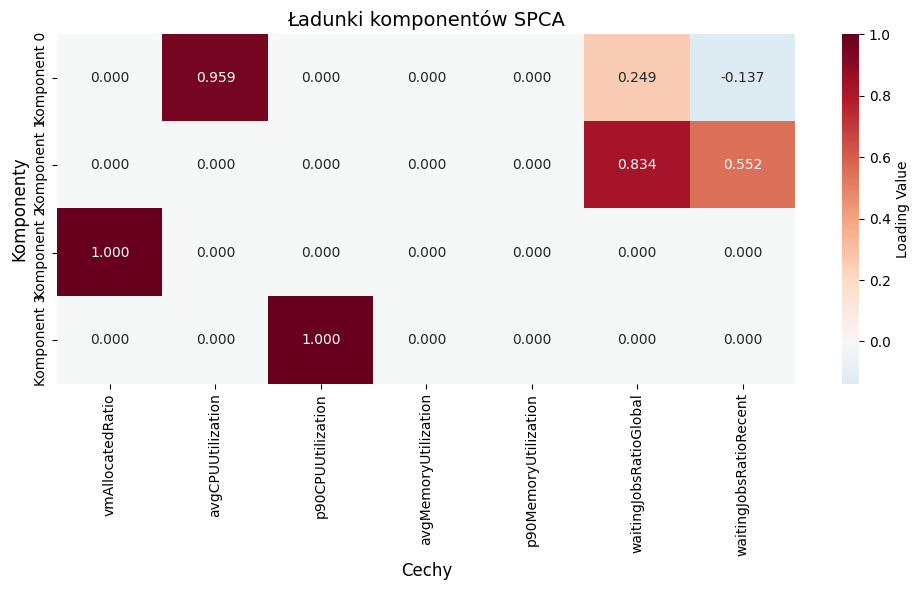

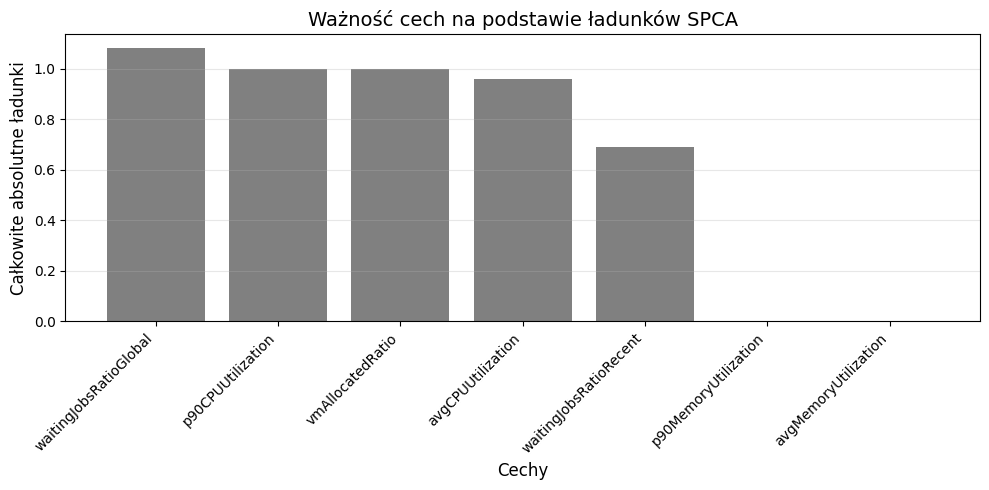

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def visualize_spca_loadings(spca_model, feature_names=None):
    """
    Visualize SPCA loadings as a heatmap.
    
    Args:
        spca_model: Fitted SparsePCA model
        feature_names: List of feature names (optional)
    """
    loadings = spca_model.components_  # Shape: (n_components, n_features)
    n_components, n_features = loadings.shape
    
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(n_features)]
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        loadings,
        annot=True,  # Show values
        fmt='.3f',   # 3 decimal places
        cmap='RdBu_r',  # Red-Blue colormap (red=positive, blue=negative)
        center=0,    # Center colormap at zero
        xticklabels=feature_names,
        yticklabels=[f'Komponent {i}' for i in range(n_components)],
        cbar_kws={'label': 'Loading Value'}
    )
    
    plt.title('Ładunki komponentów SPCA', fontsize=14)
    plt.xlabel('Cechy', fontsize=12)
    plt.ylabel('Komponenty', fontsize=12)
    plt.tight_layout()
    plt.savefig('spca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Also plot feature importance (SORTED)
    feature_importance = np.sum(np.abs(loadings), axis=0)
    
    # Sort features by importance
    sorted_indices = np.argsort(feature_importance)[::-1]  # Descending order
    sorted_importance = feature_importance[sorted_indices]
    sorted_names = [feature_names[i] for i in sorted_indices]
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(n_features), sorted_importance, color='gray')
    plt.xticks(range(n_features), sorted_names, rotation=45, ha='right')
    plt.xlabel('Cechy', fontsize=12)
    plt.ylabel('Całkowite absolutne ładunki', fontsize=12)
    plt.title('Ważność cech na podstawie ładunków SPCA', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Usage:
visualize_spca_loadings(spca, feature_names=feature_names)

## Wagi Attention

### Wagi attention - compliant with Attention during training callback

In [3]:
import numpy as np
import torch
from typing import Optional, Dict, Any, List

# --- tiny helpers (your originals) ---
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _to_1d_bool(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.ndim == 0:
        return np.array([bool(x)], dtype=bool)
    if x.ndim > 1:
        x = x.reshape(-1)
    return x

# --------- core: collect AND compute post-training stats ---------

@torch.no_grad()
def compute_attn_stats_after_training(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
    feature_names: Optional[List[str]] = None,
    top_m_for_frequency: Optional[int] = None,
    # saving (optional)
    save_npz_path: Optional[str] = None,
    save_csv_dir: Optional[str] = None,
    # which attention signal to use
    source: str = "auto",  # "auto" | "overall" | "contrib" | "metric"
    verbose: int = 1,
) -> Dict[str, Any]:
    """
    Collect episodes after training and compute attention stats like the training callback.

    Returns a dict with:
      - 'mean_per_ep'       : [E, N] per-episode mean attention
      - 'mean_over_episodes': [N]    mean(mean_per_ep, axis=0)
      - 'var_over_episodes' : [N]    sample variance across episodes of episode means
      - 'step_weighted_mean': [N]    mean over ALL steps across ALL episodes (for reference)
      - 'freq'              : [N]    episode selection frequency (top-m per episode)
      - 'order'             : [N]    ranking indices by (-freq, -mean, +var)
      - 'ep_returns'        : list[float]
      - 'feature_names'     : [N] names used
      - 'source_used'       : str   ("overall"|"contrib"|"metric")
    And optionally writes NPZ + CSVs if save paths are given.
    """
    # --------- freeze VecNormalize like in eval ---------
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv (num_envs == 1) for post-training eval.")

    # --------- pick features_extractor and source ---------
    fe = getattr(model.policy, "features_extractor", None)
    if fe is None:
        raise AttributeError("Policy has no features_extractor.")

    def _pull_attn_vec(fe):
        # prefer overall -> contrib -> metric
        if source in ("auto", "overall"):
            v = getattr(fe, "overall_importance", None)
            if v is not None:
                return v, "overall"
            if source == "overall":
                raise AttributeError("overall_importance not available on features_extractor.")
        if source in ("auto", "contrib"):
            v = getattr(fe, "contrib_importance", None)
            if v is not None:
                return v, "contrib"
            if source == "contrib":
                raise AttributeError("contrib_importance not available on features_extractor.")
        v = getattr(fe, "metric_importance", None)
        if v is None:
            raise AttributeError("No attention vectors found (need metric/contrib/overall importance).")
        return v, "metric"

    # Figure out N (feature dimension)
    N = getattr(fe, "n_metrics", None) or getattr(fe, "final_out_dim", None)
    if N is None:
        raise RuntimeError("Could not infer feature dimension (n_metrics/final_out_dim).")
    N = int(N)

    # names
    if feature_names is not None and len(feature_names) != N:
        raise ValueError(f"feature_names length {len(feature_names)} != N={N}")
    names = feature_names if feature_names is not None else [f"f{i}" for i in range(N)]

    # frequency m
    if top_m_for_frequency is None:
        # same heuristic as in callback: 2 * ceil(sqrt(N)), clipped to [1, N]
        top_m_for_frequency = max(1, min(N, 2 * int(np.ceil(np.sqrt(N)))))

    # --------- roll out episodes and collect per-step attention ---------
    attn_per_ep = []   # list of [T_ep, N]
    ep_returns = []
    source_used = None

    state = None
    for _ in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):  # gymnasium reset returns (obs, info)
            obs = obs[0]

        episode_start = np.array([True], dtype=bool) if is_vec else None
        done = False
        ret = 0.0
        ep_steps = []

        while not done:
            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(obs, state=state, deterministic=deterministic)

            # read current attention vector
            attn_tensor, src = _pull_attn_vec(fe)
            source_used = source_used or src

            v = attn_tensor.detach().cpu().numpy()
            # normalize shape to [N]
            if v.ndim == 2:  # [B, N]
                v = v[0] if v.shape[0] == 1 else v.mean(axis=0)
            elif v.ndim != 1:
                # unexpected shape -> skip this step
                v = None
            if v is not None:
                ep_steps.append(np.asarray(v, dtype=np.float32))

            # step env
            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done_scalar = _done_scalar(d)
                episode_start = _to_1d_bool(d)
            else:
                out = env.step(action)
                if isinstance(out, (list, tuple)) and len(out) == 5:
                    obs, r, terminated, truncated, info = out
                    done_scalar = bool(terminated or truncated)
                else:
                    obs, r, done_scalar, info = out
                r_scalar = float(np.asarray(r).squeeze())

            ret += r_scalar
            done = done_scalar

        state = None
        ep_returns.append(ret)
        if len(ep_steps) == 0:
            attn_per_ep.append(np.zeros((1, N), dtype=np.float32))
        else:
            attn_per_ep.append(np.stack(ep_steps, axis=0))  # [T_ep, N]

    E = len(attn_per_ep)
    if E == 0:
        raise RuntimeError("No episodes collected.")

    # --------- compute stats (episode-level like the callback) ---------
    # per-episode means
    mean_per_ep = np.stack([A.mean(axis=0) for A in attn_per_ep], axis=0)  # [E, N]

    # unweighted mean across episodes (callback semantics)
    mean_over_episodes = mean_per_ep.mean(axis=0)                           # [N]

    # sample variance across episodes (of episode means)
    if E >= 2:
        var_over_episodes = mean_per_ep.var(axis=0, ddof=1)                 # [N]
    else:
        var_over_episodes = np.zeros(N, dtype=np.float32)

    # step-weighted mean over all steps (not used for ranking, but informative)
    step_weighted_mean = np.mean(np.concatenate(attn_per_ep, axis=0), axis=0)

    # frequency: how often feature in episode top-m
    m = int(top_m_for_frequency)
    freq = np.zeros(N, dtype=np.float32)
    for e in range(E):
        idx = np.argpartition(-mean_per_ep[e], m - 1)[:m]
        freq[idx] += 1.0
    freq /= float(E)

    # combined ranking: (-freq, -mean, +var)
    order = np.lexsort((var_over_episodes, -mean_over_episodes, -freq))

    if verbose:
        k = min(20, N)
        print(f"[PosthocAttention] Episodes={E}, N={N}, top_m={m}, source={source_used}")
        print(f"  Top-{k} features (by freq desc, mean desc, var asc):")
        for rank, i in enumerate(order[:k], 1):
            print(f"    {rank:>2}. {names[i]} (idx={i})  freq={freq[i]:.3f}  mean={mean_over_episodes[i]:.6f}  var={var_over_episodes[i]:.6f}")

    # --------- optional save ---------
    if save_npz_path is not None:
        np.savez(
            save_npz_path,
            mean_per_ep=mean_per_ep,
            mean_over_episodes=mean_over_episodes,
            var_over_episodes=var_over_episodes,
            step_weighted_mean=step_weighted_mean,
            freq=freq,
            order=order,
            ep_returns=np.asarray(ep_returns, dtype=np.float32),
            feature_names=np.asarray(names),
            source_used=np.asarray(source_used or "", dtype=np.str_),
        )
        if verbose:
            print(f"[PosthocAttention] Saved NPZ to: {save_npz_path}")

    if save_csv_dir is not None:
        try:
            import os, pandas as pd
            os.makedirs(save_csv_dir, exist_ok=True)
            # final vectors
            pd.DataFrame({
                "feature": names,
                "freq": freq,
                "mean": mean_over_episodes,
                "var": var_over_episodes,
                "step_weighted_mean": step_weighted_mean,
            }).to_csv(os.path.join(save_csv_dir, "attn_posthoc_final.csv"), index=False)
            # per-episode means
            df_me = pd.DataFrame(mean_per_ep, columns=names)
            df_me.to_csv(os.path.join(save_csv_dir, "attn_posthoc_mean_per_episode.csv"), index_label="episode")
            # ranking
            pd.DataFrame({
                "rank": np.arange(1, N+1),
                "idx": order,
                "feature": [names[i] for i in order],
                "freq": [freq[i] for i in order],
                "mean": [mean_over_episodes[i] for i in order],
                "var":  [var_over_episodes[i] for i in order],
            }).to_csv(os.path.join(save_csv_dir, "attn_posthoc_ranking.csv"), index=False)
            # returns
            pd.DataFrame({"episode": np.arange(E), "return": ep_returns}).to_csv(
                os.path.join(save_csv_dir, "attn_posthoc_episode_returns.csv"), index=False
            )
            if verbose:
                print(f"[PosthocAttention] Saved CSVs to: {save_csv_dir}")
        except Exception as e:
            if verbose:
                print(f"[PosthocAttention] CSV save skipped due to: {e}")

    return {
        "mean_per_ep": mean_per_ep,
        "mean_over_episodes": mean_over_episodes,
        "var_over_episodes": var_over_episodes,
        "step_weighted_mean": step_weighted_mean,
        "freq": freq,
        "order": order,
        "ep_returns": ep_returns,
        "feature_names": names,
        "source_used": source_used or "metric",
    }


In [4]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\GAWRL_FULL_MODEL_contrib_evaluation\final_trained\attention_MlpPolicy_mlplstm_attention.zip')

In [5]:
from utils import FEATURE_NAMES
stats = compute_attn_stats_after_training(
    env,
    model,
    n_episodes=20,
    deterministic=True,
    feature_names=FEATURE_NAMES,
    top_m_for_frequency=None,              # use default 2*ceil(sqrt(N))
    save_npz_path="logs/attn_posthoc_final.npz",
    save_csv_dir="logs/attn_posthoc_csv",
    source="auto",                         # or "overall" / "contrib" / "metric"
    verbose=1,
)

# Example: top-15 names
order = stats["order"]
names = stats["feature_names"]
print([names[i] for i in order[:15]])


[PosthocAttention] Episodes=20, N=7, top_m=6, source=contrib
  Top-7 features (by freq desc, mean desc, var asc):
     1. vmAllocatedRatio (idx=0)  freq=1.000  mean=0.747702  var=0.000001
     2. avgCPUUtilization (idx=1)  freq=1.000  mean=0.124504  var=0.000001
     3. waitingJobsRatioGlobal (idx=5)  freq=1.000  mean=0.072096  var=0.000000
     4. waitingJobsRatioRecent (idx=6)  freq=1.000  mean=0.015698  var=0.000000
     5. p90CPUUtilization (idx=2)  freq=1.000  mean=0.000000  var=0.000000
     6. p90MemoryUtilization (idx=4)  freq=1.000  mean=0.000000  var=0.000000
     7. avgMemoryUtilization (idx=3)  freq=0.000  mean=0.000000  var=0.000000
[PosthocAttention] Saved NPZ to: logs/attn_posthoc_final.npz
[PosthocAttention] Saved CSVs to: logs/attn_posthoc_csv
['vmAllocatedRatio', 'avgCPUUtilization', 'waitingJobsRatioGlobal', 'waitingJobsRatioRecent', 'p90CPUUtilization', 'p90MemoryUtilization', 'avgMemoryUtilization']


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Sequence

def plot_posthoc_mean_bar(
    stats: dict,
    top_k: int = 20,
    FEATURE_NAMES: Optional[Sequence[str]] = None,  # preferred names
    sort_by: str = "mean",                          # "mean" or "order" (uses stats["order"])
    show_std: bool = True,                          # draw std(error) bars from episode means
    title: Optional[str] = None,
    save_path: Optional[str] = None,
    figsize: Tuple[float, float] = (10, 5),
):
    """
    Bar plot of top-k features by post-training mean attention (per-episode mean).
    - Uses FEATURE_NAMES if given and length matches N; otherwise falls back to stats["feature_names"] or f{i}.
    - sort_by="mean": sort by mean_over_episodes descending
      sort_by="order": use stats["order"] (already combined rank: -freq, -mean, +var)
    """
    mean = np.asarray(stats["mean_over_episodes"])   # [N]
    var  = np.asarray(stats.get("var_over_episodes", np.zeros_like(mean)))
    N    = mean.shape[0]

    # pick names (prefer provided FEATURE_NAMES)
    names = None
    if FEATURE_NAMES is not None and len(FEATURE_NAMES) == N:
        names = np.asarray(FEATURE_NAMES, dtype=str)
    else:
        names = np.asarray(stats.get("feature_names", [f"f{i}" for i in range(N)]), dtype=str)

    # choose ordering
    if sort_by == "order" and "order" in stats:
        order = np.asarray(stats["order"])
    else:
        order = np.argsort(-mean)
    k = int(min(top_k, N))
    idx = order[:k]

    # plot
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    if show_std:
        # std across episodes of the episode means
        std = np.sqrt(var[idx])
        ax.bar(range(k), mean[idx], yerr=std, capsize=3)
    else:
        ax.bar(range(k), mean[idx])

    ax.set_xticks(range(k))
    ax.set_xticklabels([f"{names[i]} (#{i})" for i in idx], rotation=45, ha="right")
    ax.set_ylabel("Mean attention (per episode)")
    src = stats.get("source_used", "")
    ax.set_title(title or f"Top {k} features by mean attention" + (f" · {src}" if src else ""))
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")

    return fig, ax, idx  # idx are the plotted (sorted) feature indices


In [7]:

plot_posthoc_mean_bar(
    stats,
    top_k=7,
    FEATURE_NAMES=FEATURE_NAMES,       # or omit to use names saved in stats
    sort_by="order",                   # uses combined ranking (-freq, -mean, +var)
    show_std=True,
    save_path="logs/attn_posthoc_top7.png"
)

(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Top 7 features by mean attention · contrib'}, ylabel='Mean attention (per episode)'>,
 array([0, 1, 5, 6, 2, 4, 3], dtype=int64))

### Sposób 1

In [8]:
import numpy as np
import torch

# --- tiny helpers copied from your evaluate() ---
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _to_1d_bool(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.ndim == 0:
        return np.array([bool(x)], dtype=bool)
    if x.ndim > 1:
        x = x.reshape(-1)
    return x

# --- evaluate-like attention collector ---
@torch.no_grad()
def collect_attn_per_episode(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
):
    """
    Returns:
      attn_per_ep: list of arrays; each is [T_ep, N] with per-step metric_importance
      mean_per_ep: array [E, N] mean attention per episode
      mean_all   : array [N] mean across all steps of all episodes
      ep_returns : list[float] episode returns (true env reward if VecNormalize present)
    """
    # Freeze VecNormalize the same way evaluate() does
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    # Sanity: single env only (VecEnv or raw Gym)
    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("collect_attn_per_episode expects a single-env VecEnv (num_envs == 1).")

    fe = getattr(model.policy, "features_extractor", None)
    if fe is None or not hasattr(fe, "metric_importance"):
        raise AttributeError("Policy features_extractor missing 'metric_importance' "
                             "(use AdaptiveAttentionFeatureExtractor).")

    attn_per_ep = []
    ep_returns = []

    state = None
    for _ in range(n_episodes):
        obs = env.reset()
        # Gymnasium may return (obs, info)
        if isinstance(obs, tuple):
            obs = obs[0]

        episode_start = np.array([True], dtype=bool) if is_vec else None
        done = False
        ret = 0.0
        ep_steps = []

        while not done:
            # SB3 predict: try with episode_start (for RecurrentPPO); fallback if not supported
            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(
                    obs, state=state, deterministic=deterministic
                )

            # Record current-step attention (based on current obs)
            mi = fe.metric_importance
            if mi is not None:
                mi_np = mi.detach().cpu().numpy()
                if mi_np.ndim == 2:
                    # [B, N]; with single env B==1
                    ep_steps.append(mi_np[0].copy() if mi_np.shape[0] == 1 else mi_np.mean(axis=0).copy())
                elif mi_np.ndim == 1:
                    ep_steps.append(mi_np.copy())
                # else: ignore unexpected shape

            # Step env (support Gymnasium 5-tuple and classic Gym 4-tuple; VecEnv vs raw Gym)
            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done_scalar = _done_scalar(d)
                episode_start = _to_1d_bool(d)
            else:
                step_out = env.step(action)
                if len(step_out) == 5:
                    obs, r, terminated, truncated, info = step_out
                    done_scalar = bool(terminated or truncated)
                else:
                    obs, r, done_scalar, info = step_out
                r_scalar = float(np.asarray(r).squeeze())

            ret += r_scalar
            done = done_scalar

        # episode end
        state = None
        ep_returns.append(ret)

        if len(ep_steps) == 0:
            # create zeros of correct size
            N = getattr(fe, "n_metrics", None) or getattr(fe, "final_out_dim", None)
            if N is None:
                raise RuntimeError("Could not infer feature dimension for attention.")
            attn_per_ep.append(np.zeros((1, int(N)), dtype=np.float32))
        else:
            attn_per_ep.append(np.stack(ep_steps, axis=0))  # [T_ep, N]

    # Means
    mean_per_ep = np.stack([A.mean(axis=0) for A in attn_per_ep], axis=0)  # [E, N]
    mean_all = np.mean(np.concatenate(attn_per_ep, axis=0), axis=0)        # [N]
    return attn_per_ep, mean_per_ep, mean_all
#ep_returns


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Collect per-episode attention from AdaptiveAttentionFeatureExtractor
# (works with SB3 VecEnv, num_envs == 1)
# ============================================================

# def collect_attn_per_episode(env, model, n_episodes=10, deterministic=True):
#     """
#     Returns:
#       attn_per_ep: list of arrays; each is [T_ep, N] with per-step metric_importance
#       mean_per_ep: array [E, N] mean attention per episode
#       mean_all   : array [N] mean across all steps of all episodes
#     """
#     # Sanity: this helper assumes a single env in the VecEnv
#     num_envs = getattr(env, "num_envs", 1)
#     if num_envs != 1:
#         raise ValueError(f"collect_attn_per_episode assumes num_envs == 1, got {num_envs}")

#     fe = model.policy.features_extractor
#     if not hasattr(fe, "metric_importance"):
#         raise AttributeError("Policy features_extractor has no 'metric_importance'. "
#                              "Make sure you're using AdaptiveAttentionFeatureExtractor.")

#     attn_per_ep = []

#     for _ in range(n_episodes):
#         obs = env.reset()                    # (1, N) from VecEnv
#         lstm_states = None
#         episode_start = True
#         ep_steps = []

#         while True:
#             # Run policy one step
#             action, lstm_states = model.predict(
#                 obs,
#                 state=lstm_states,
#                 episode_start=np.array([episode_start]),
#                 deterministic=deterministic,
#             )

#             # Read the latest per-step attention vector from the extractor
#             # metric_importance is [B, N]; with num_envs=1 => [1, N]
#             mi = fe.metric_importance
#             if mi is not None:
#                 mi_np = mi.detach().cpu().numpy()
#                 if mi_np.ndim == 2 and mi_np.shape[0] == 1:
#                     ep_steps.append(mi_np[0].copy())
#                 else:
#                     # fallback if something changed the batch shape
#                     ep_steps.append(np.mean(mi_np, axis=0).copy())

#             # Step the env (VecEnv v0 API: obs, rewards, dones, infos)
#             if np.isscalar(action):
#                 actions = np.array([action])
#             else:
#                 actions = np.asarray(action)

#             obs, rewards, dones, infos = env.step(actions)
#             episode_start = bool(dones[0])
#             if episode_start:
#                 break

#         if len(ep_steps) == 0:
#             # if for some reason we didn't record, create zeros of correct size
#             N = getattr(fe, "n_metrics", None)
#             if N is None and hasattr(fe, "final_out_dim"):
#                 N = int(fe.final_out_dim)
#             if N is None:
#                 raise RuntimeError("Could not infer feature dimension to store episode attention.")
#             attn_per_ep.append(np.zeros((1, N), dtype=np.float32))
#         else:
#             attn_per_ep.append(np.stack(ep_steps, axis=0))  # [T_ep, N]

#     # Means
#     mean_per_ep = np.stack([A.mean(axis=0) for A in attn_per_ep], axis=0)  # [E, N]
#     mean_all = np.mean(np.concatenate(attn_per_ep, axis=0), axis=0)        # [N]
#     return attn_per_ep, mean_per_ep, mean_all


# ============================================================
# Plotting helpers
# ============================================================

def plot_mean_attention_bar(mean_vec, feature_names=None, title="Mean attention per feature"):
    N = mean_vec.shape[0]
    idx = np.argsort(-np.abs(mean_vec))
    names = feature_names or [f"f{i}" for i in range(N)]

    x = np.arange(N)
    plt.figure(figsize=(10, 5))
    plt.bar(x, mean_vec[idx], alpha=0.9)
    plt.axhline(0, color="k", lw=0.8)
    plt.xticks(x, [names[i] for i in idx], rotation=40, ha="right")
    plt.ylabel("Średnie wagi Attention")
    plt.title(title, fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_attention_heatmap(mean_per_ep, feature_names=None, title="Per-episode mean attention (E × N)"):
    """
    mean_per_ep: [E, N]
    """
    E, N = mean_per_ep.shape
    names = feature_names or [f"f{i}" for i in range(N)]

    # sort columns by |overall mean|
    col_order = np.argsort(-np.abs(mean_per_ep.mean(axis=0)))
    A = mean_per_ep[:, col_order]

    plt.figure(figsize=(7, max(2.5, 0.2 * E + 2)))
    vmax = np.percentile(np.abs(A), 99) if A.size > 0 else 1.0
    plt.imshow(A, aspect="auto", cmap="bwr", vmin=-vmax, vmax=vmax)
    plt.colorbar(label="attention")
    plt.yticks(np.arange(E), [f"ep{i}" for i in range(E)])
    plt.xticks(np.arange(N), [names[j] for j in col_order], rotation=40, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [10]:
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO

#model = PPO.load(r'c:\initial_model\historic_synthetic_dnnevo\RANDOM\MLP\attention_gawrl_mlp_ppo_2\attention_MlpPolicy_mlp_attention.zip',env=env)
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\gawrl_all_stages\attention_MlpPolicy_attention_10_000.zip')
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\generalized_recurrentppo_81\attention_MlpPolicy_mlplstm_attention.zip', env=env)
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\gawrl_all_stages\ppo_mlp_intermediate_00_100000.zip')
#model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\gawrl_all_stages\ppo_mlp_intermediate_04_500000.zip')
model = RecurrentPPO.load(r'c:\initial_model\historic_synthetic_dnnevo\ATTENTTION\GAWRL_FULL_MODEL\attention_MlpPolicy_mlplstm_attention.zip')

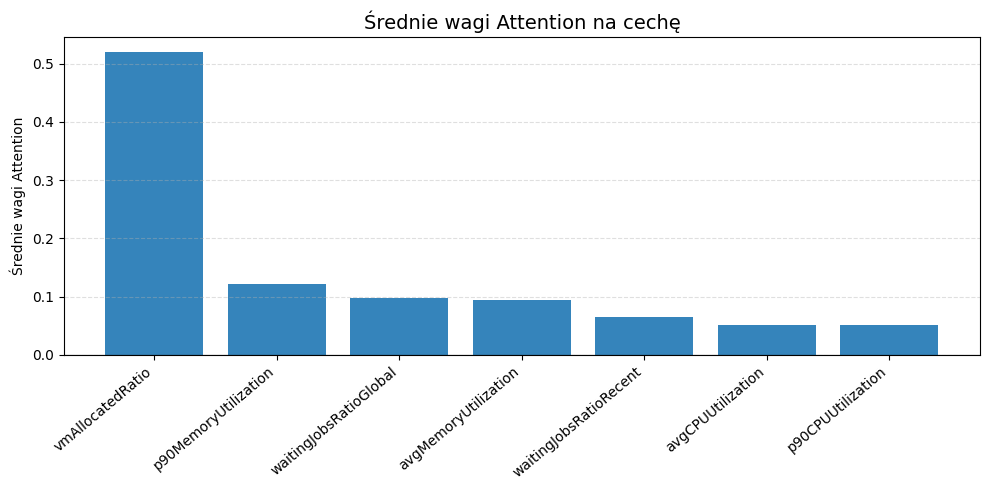

In [11]:
# Example (assuming you already loaded model and built eval env):
# from sb3_contrib import RecurrentPPO
# model = RecurrentPPO.load("path/to/model.zip", device="cpu")
# env = your_vec_env_factory(...)
%matplotlib inline
from utils import FEATURE_NAMES
attn_per_ep, mean_per_ep, mean_all = collect_attn_per_episode(env, model, n_episodes=100, deterministic=True)
#attn_per_ep, mean_per_ep, mean_all, ep_returns, acts_per_ep, preds_per_ep, obs_per_ep = collect_attn_preds_obs_per_episode(env, model, n_episodes=100, deterministic=True)
# Bar chart of overall mean attention across all steps/episodes:
feature_names = FEATURE_NAMES # or your own names
plot_mean_attention_bar(mean_all, feature_names, title="Średnie wagi Attention na cechę")



### Wagi Attention - sposób 3

Tutaj dostaję takie same rankingi

In [24]:
import numpy as np

def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _to_1d_bool(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.ndim == 0:
        return np.array([bool(x)], dtype=bool)
    if x.ndim > 1:
        x = x.reshape(-1)
    return x

def _read_attn_from_model(model):
    fx = getattr(getattr(model, "policy", None), "features_extractor", None)
    if fx is None:
        return None, None
    try:
        import torch as _th
        def _is_tensor(t): return _th.is_tensor(t)
        def _to_np(t, squeeze=True):
            if t is None: return None
            if _is_tensor(t): t = t.detach().cpu().numpy()
            else: t = np.asarray(t)
            return np.squeeze(t) if squeeze else t
    except Exception:
        def _to_np(t, squeeze=True):
            if t is None: return None
            t = np.asarray(t)
            return np.squeeze(t) if squeeze else t

    vec = _to_np(getattr(fx, "metric_importance", None), squeeze=True)
    mat = _to_np(getattr(fx, "attn_matrix", None), squeeze=False)
    if vec is not None and vec.ndim == 2:
        vec = vec[0]
    if mat is not None and mat.ndim == 3:
        mat = mat[0]
    return vec, mat

def _overall_mean_attention(attn_steps_by_ep):
    # Flatten all step vectors across episodes and average -> [N]
    all_vecs = []
    for ep in attn_steps_by_ep or []:
        if ep:
            for v in ep:
                if v is not None:
                    all_vecs.append(np.asarray(v))
    if not all_vecs:
        return None
    arr = np.stack(all_vecs, axis=0)  # [T_total, N]
    return arr.mean(axis=0)

def plot_mean_attention(attention_payload, feature_names=None, title="Mean attention (all steps)",
                        save_path=None, show=True):
    """
    Bar plot of mean attention from an attention payload returned by `evaluate(..., collect_attention=True)`.
    """
    import matplotlib.pyplot as plt

    mean_vec = attention_payload.get("overall_mean", None)
    if mean_vec is None:
        # fall back to recompute from per_step if needed
        mean_vec = _overall_mean_attention(attention_payload.get("per_step", []))
        if mean_vec is None:
            raise ValueError("No attention vectors found to plot.")

    N = len(mean_vec)
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(N)]
    else:
        assert len(feature_names) == N, "feature_names length must match number of features"

    idx = np.arange(N)
    fig, ax = plt.subplots()
    ax.bar(idx, mean_vec)  # no explicit colors; single-figure plot
    ax.set_xticks(idx)
    ax.set_xticklabels(feature_names, rotation=45, ha="right")
    ax.set_ylabel("Mean attention")
    ax.set_title(title)
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150)
    if show:
        plt.show()
    else:
        plt.close(fig)

def evaluate(model, env, n_episodes=15, deterministic=False,
             freeze_vecnorm=True, collect_info=False,
             collect_attention=False, return_attn_matrix=False,
             visualize_attention=False,  # NEW: draw bar plot at the end
             feature_names=None,         # optional x-axis labels
             save_plot_path=None,        # optional file to save the plot
             show_plot=False):           # call plt.show(); defaults False for headless runs
    """
    Evaluate a single-env environment and (optionally) collect + visualize attention.

    If collect_attention=True, the returned `attention` dict now also contains:
        - "overall_mean": np.ndarray shape [N] with mean attention over all steps.
        - "feature_names": the labels used for plotting (if provided).

    When visualize_attention=True, a bar plot is produced using matplotlib.
    """
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv for eval.")

    state = None
    ep_returns, observations, actions = [], [], []
    raw_obs_trace, raw_metrics_trace = [], []

    attn_steps_by_ep = [] if collect_attention else None
    attn_means_by_ep = [] if collect_attention else None
    attn_mats_by_ep  = [] if (collect_attention and return_attn_matrix) else None

    for _ in range(n_episodes):
        obs = env.reset()
        episode_start = np.array([True], dtype=bool) if is_vec else None
        done = False
        ret = 0.0

        ep_attn_steps = [] if collect_attention else None
        ep_attn_mats  = [] if (collect_attention and return_attn_matrix) else None

        while not done:
            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(
                    obs, state=state, deterministic=deterministic
                )

            if collect_attention:
                vec, mat = _read_attn_from_model(model)
                if vec is not None: ep_attn_steps.append(vec)
                if return_attn_matrix and (mat is not None): ep_attn_mats.append(mat)

            if is_vec:
                obs, r, d, info = env.step(action)
                observations.append(obs)
                actions.append(action)

                r_scalar = _scalar(r)
                done_scalar = _done_scalar(d)
                episode_start = _to_1d_bool(d)

                if collect_info:
                    i0 = info[0] if isinstance(info, (list, tuple)) else info
                    raw_obs_trace.append(i0.get("_raw_obs"))
                    raw_metrics_trace.append(i0.get("_raw_metrics"))
            else:
                obs, r, d, info = env.step(action)
                observations.append(obs)
                actions.append(action)
                r_scalar = float(r)
                done_scalar = bool(d)
                if collect_info:
                    raw_obs_trace.append(info.get("_raw_obs"))
                    raw_metrics_trace.append(info.get("_raw_metrics"))

            ret += r_scalar
            done = done_scalar

        ep_returns.append(ret)
        state = None

        if collect_attention:
            attn_steps_by_ep.append(ep_attn_steps)
            if ep_attn_steps and len(ep_attn_steps) > 0:
                attn_means_by_ep.append(np.mean(np.stack(ep_attn_steps, axis=0), axis=0))
            else:
                attn_means_by_ep.append(None)
            if return_attn_matrix:
                attn_mats_by_ep.append(ep_attn_mats)

    mean_return = float(np.mean(ep_returns)) if ep_returns else 0.0

    if collect_attention:
        overall_mean = _overall_mean_attention(attn_steps_by_ep)
        attention_payload = {
            "per_step": attn_steps_by_ep,
            "per_episode_mean": attn_means_by_ep,
            "per_step_matrices": attn_mats_by_ep if return_attn_matrix else None,
            "overall_mean": overall_mean,
            "feature_names": feature_names,
        }

        # Optional: visualize as bar plot
        if visualize_attention and overall_mean is not None:
            plot_mean_attention(attention_payload,
                                feature_names=feature_names,
                                title="Mean attention (across collected observations)",
                                save_path=save_plot_path,
                                show=show_plot)

        if collect_info:
            return mean_return, raw_obs_trace, ep_returns, actions, attention_payload
        else:
            return mean_return, observations, ep_returns, actions, attention_payload
    else:
        if collect_info:
            return mean_return, raw_obs_trace, ep_returns, actions
        else:
            return mean_return, observations, ep_returns, actions


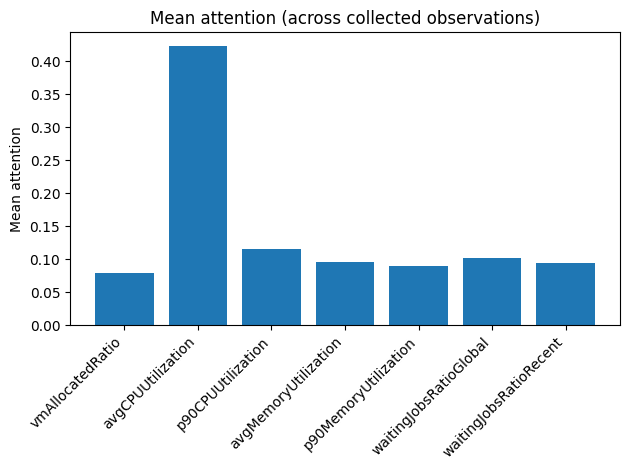

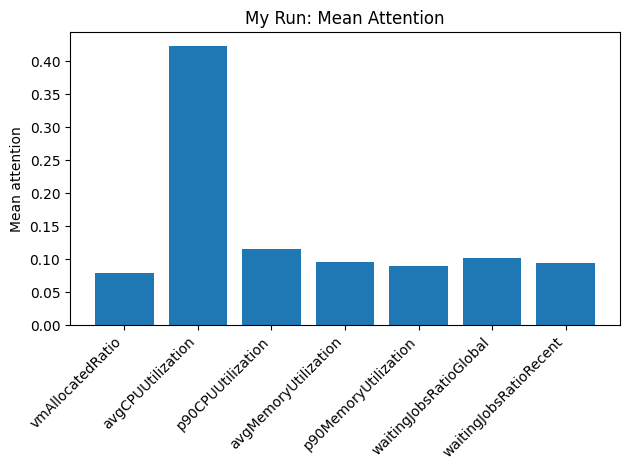

In [26]:
mean_ret, obs, ep_returns, actions, attn = evaluate(
    model, env,
    n_episodes=100,
    collect_attention=True,
    visualize_attention=True,     # make the bar plot immediately
    feature_names=FEATURE_NAMES,
    save_plot_path="mean_attention.png",
    show_plot=True
)

# or plot later:
plot_mean_attention(attn, feature_names=attn.get("feature_names"),
                    title="My Run: Mean Attention", save_path=None, show=True)

### Wagi Attention - sposób 2

In [6]:
# # ============================================
# # Attention-based feature ranking & selection
# # Works with AdaptiveAttentionFeatureExtractor (AWRL)
# # ============================================

# from __future__ import annotations
# from typing import List, Tuple, Optional
# import numpy as np
# import pandas as pd
# import torch

# # ---------- small helpers ----------

# def _get_feat_extractor(model):
#     """
#     Locate your AdaptiveAttentionFeatureExtractor inside SB3 policy.
#     Change this if your attribute path differs.
#     """
#     fx = getattr(model.policy, "features_extractor", None)
#     if fx is None:
#         raise AttributeError("model.policy.features_extractor not found")
#     # quick sanity: must expose .metric_importance and .attn_history
#     if not hasattr(fx, "metric_importance") or not hasattr(fx, "attn_history"):
#         raise AttributeError("features_extractor does not expose .metric_importance / .attn_history")
#     return fx

# def _reset_attn_stats(fx):
#     # clear rolling attention stats inside the extractor
#     try:
#         fx.attn_history.clear()
#     except Exception:
#         pass
#     if hasattr(fx, "total_steps"):
#         fx.total_steps = 0

# def _zscore_running_update(x, mean, M2, n):
#     # Welford’s online updates per-feature
#     n += 1
#     delta = x - mean
#     mean = mean + delta / n
#     M2 = M2 + delta * (x - mean)
#     return mean, M2, n

# def _zscore_finish(x, mean, M2, n):
#     var = np.maximum(M2 / max(n - 1, 1), 1e-12)
#     std = np.sqrt(var)
#     return (x - mean) / (std + 1e-8)

# def _env_reset(env):
#     out = env.reset()
#     if isinstance(out, tuple) and len(out) >= 1:
#         return out[0]
#     return out

# def _env_step(env, action):
#     out = env.step(action)
#     # gymnasium: (obs, reward, terminated, truncated, info)
#     if isinstance(out, tuple) and len(out) == 5:
#         obs, r, terminated, truncated, info = out
#         done = bool(terminated or truncated)
#         return obs, r, done, info
#     # gym classic: (obs, reward, done, info)
#     if isinstance(out, tuple) and len(out) == 4:
#         obs, r, done, info = out
#         return obs, r, bool(done), info
#     raise RuntimeError("Unexpected env.step() return format")

# # ---------- main: rank by attention ----------

# @torch.no_grad()
# def rank_features_by_attention_awrl(
#     model,
#     env,
#     metric_names: List[str],
#     episodes: int = 20,
#     deterministic: bool = True,
#     use_attn_x_input: bool = True,   # if True -> average Attn × |z-scored input|
# ) -> Tuple[np.ndarray, List[int], List[str]]:
#     """
#     Runs episodes, reads per-feature attention from your extractor, and ranks metrics.

#     Returns:
#         scores: np.array[D]   (average score per feature)
#         order : list[int]     (indices sorted desc)
#         ranked_names: list[str]
#     """
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     fx = _get_feat_extractor(model)
#     _reset_attn_stats(fx)

#     D = len(metric_names)
#     scores = np.zeros(D, dtype=np.float64)
#     count = 0

#     # running stats for Attn×Input
#     mean = np.zeros(D, dtype=np.float64)
#     M2   = np.zeros(D, dtype=np.float64)
#     n    = 0

#     ep = 0
#     obs = _env_reset(env)
#     state = None
#     while ep < episodes:
#         # SB3's predict uses no_grad; that is fine (we only read cached attention)
#         action, state = model.predict(obs, state=state, deterministic=deterministic)
#         nxt, r, done, info = _env_step(env, action)

#         # pull current feature-importance vector from extractor (shape [B,N] or [N])
#         att = getattr(fx, "metric_importance", None)
#         if att is not None:
#             att = att.detach()
#             if att.dim() == 2:
#                 # [B,N] -> assume single env or take first env
#                 att_vec = att[0].cpu().numpy()
#             elif att.dim() == 1:
#                 att_vec = att.cpu().numpy()
#             else:
#                 att_vec = None
#         else:
#             att_vec = None

#         if att_vec is not None and np.isfinite(att_vec).all():
#             # align to first D metrics
#             att_vec = np.asarray(att_vec, dtype=np.float64).ravel()[:D]

#             if use_attn_x_input:
#                 x_vec = np.asarray(obs, dtype=np.float64).ravel()[:D]
#                 mean, M2, n = _zscore_running_update(x_vec, mean, M2, n)
#                 xz = np.abs(_zscore_finish(x_vec, mean, M2, n))
#                 scores += att_vec * xz
#             else:
#                 scores += att_vec
#             count += 1

#         obs = nxt
#         if done:
#             ep += 1
#             state = None
#             obs = _env_reset(env)

#     if count == 0:
#         raise RuntimeError("No attention captured. Ensure your extractor runs in the policy forward.")
#     scores /= float(count)

#     order = np.argsort(-scores).tolist()
#     ranked_names = [metric_names[i] for i in order]
#     return scores, order, ranked_names

# # ---------- (optional) de-duplication via partial correlations ----------

# def dedupe_with_partial_corr(
#     df: pd.DataFrame,
#     cand_names: List[str],
#     k: int = 3,
#     method: str = "spearman",
# ) -> List[str]:
#     """
#     Greedy: start with the least-correlated-to-others, then add metrics with
#     smallest mean absolute correlation to the selected set.
#     """
#     C = df[cand_names].corr(method=method).abs()
#     np.fill_diagonal(C.values, np.nan)
#     mean_corr = C.mean().sort_values()
#     selected = [mean_corr.index[0]]
#     for _ in range(1, min(k, len(cand_names))):
#         best, best_score = None, 1e9
#         for c in C.index.difference(selected):
#             sc = C.loc[c, selected].mean()
#             if sc < best_score:
#                 best, best_score = c, sc
#         selected.append(best)
#     return selected

# # ---------- apply mask back to extractor ----------

# def apply_selected_mask_to_extractor(
#     model,
#     metric_names: List[str],
#     selected_names: List[str],
# ):
#     """
#     Build a boolean mask [N] and push it to your AdaptiveAttentionFeatureExtractor.
#     """
#     fx = _get_feat_extractor(model)
#     idx = {name: i for i, name in enumerate(metric_names)}
#     mask_arr = np.zeros(len(metric_names), dtype=np.float32)
#     for name in selected_names:
#         if name not in idx:
#             raise KeyError(f"Metric '{name}' not found in metric_names")
#         mask_arr[idx[name]] = 1.0
#     fx.set_active_mask(torch.tensor(mask_arr, dtype=torch.float32, device=fx.active_mask.device))

# # ---------- end-to-end convenience pipeline ----------

# def attention_selection_pipeline(
#     model,
#     env,
#     metric_names: List[str],
#     episodes: int = 20,
#     k_keep: int = 3,
#     use_attn_x_input: bool = True,
#     dedupe: bool = False,
#     dedupe_pool: int = 5,
# ) -> List[str]:
#     """
#     1) Rank by attention (or Attn×Input).
#     2) Optionally de-duplicate with partial correlations on a short rollout.
#     3) Apply mask to the extractor.

#     Returns: selected metric names (length k_keep).
#     """
#     # 1) attention ranking
#     scores, order, ranked = rank_features_by_attention_awrl(
#         model, env, metric_names, episodes=episodes, use_attn_x_input=use_attn_x_input
#     )
#     topk = ranked[:k_keep]

#     # 2) optional de-duplication (needs a small buffer of observations)
#     if dedupe:
#         rows = []
#         obs = _env_reset(env); state = None
#         steps = 1000
#         for _ in range(steps):
#             act, state = model.predict(obs, state=state, deterministic=True)
#             rows.append(dict(zip(metric_names, np.asarray(obs).ravel()[:len(metric_names)])))
#             obs, r, done, info = _env_step(env, act)
#             if done:
#                 state = None
#                 obs = _env_reset(env)
#         df = pd.DataFrame(rows)
#         pool = ranked[:max(k_keep, dedupe_pool)]
#         topk = dedupe_with_partial_corr(df, pool, k=k_keep)

#     # 3) push mask to extractor
#     apply_selected_mask_to_extractor(model, metric_names, topk)
#     return topk

# # ---------- OPTIONAL: use extractor's built-in history mask ----------

# def select_via_extractor_mask(
#     model,
#     keep_top_k: Optional[int] = 3,
#     threshold: Optional[float] = None
# ) -> List[int]:
#     """
#     Uses AdaptiveAttentionFeatureExtractor.get_feature_mask() which relies on its
#     internal rolling mean of attention over the last ~1000 steps.
#     Returns indices of features to keep.
#     """
#     fx = _get_feat_extractor(model)
#     mask = fx.get_feature_mask(keep_top_k=keep_top_k, threshold=threshold)  # torch.bool [N]
#     idx = torch.nonzero(mask, as_tuple=False).view(-1).tolist()
#     return idx


In [10]:
from utils import evaluate
mean_return, raw_obs_trace, ep_returns, actions = evaluate(model, env, n_episodes=10)

In [11]:
observations = raw_obs_trace

In [ ]:
import numpy as np
import gym
from stable_baselines3 import PPO
from sklearn.decomposition import SparsePCA
from collections import defaultdict

def collect_observations(model, env, n_episodes=100):
    """
    Collect observations from trained PPO model.
    
    Args:
        model: Trained SB3 PPO model
        env: Gym environment
        n_episodes: Number of episodes to collect
    
    Returns:
        np.array: All observations collected (n_timesteps, n_features)
    """
    all_observations = []
    
    for episode in range(n_episodes):
        obs = env.reset()
        done = False
        episode_obs = []
        
        while not done:
            episode_obs.append(obs)
            
            # Get action from trained policy
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
        
        all_observations.extend(episode_obs)
        
        if (episode + 1) % 10 == 0:
            print(f"Collected {episode + 1}/{n_episodes} episodes, "
                  f"total timesteps: {len(all_observations)}")
    
    return np.array(all_observations)

In [6]:
# ============================================
# Attention-based feature ranking & selection
# (OFFLINE: uses pre-collected observations)
# ============================================

from __future__ import annotations
from typing import List, Tuple, Optional, Sequence, Union
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ---------- small helpers ----------

def _get_feat_extractor(model):
    """
    Locate AdaptiveAttentionFeatureExtractor inside SB3 policy.
    """
    fx = getattr(model.policy, "features_extractor", None)
    if fx is None:
        raise AttributeError("model.policy.features_extractor not found")
    if not hasattr(fx, "metric_importance") or not hasattr(fx, "attn_history"):
        raise AttributeError("features_extractor does not expose .metric_importance / .attn_history")
    return fx

def _reset_attn_stats(fx):
    try:
        fx.attn_history.clear()
    except Exception:
        pass
    if hasattr(fx, "total_steps"):
        fx.total_steps = 0

def _to_2d_obs_array(
    observations: Union[np.ndarray, Sequence[np.ndarray]]
) -> np.ndarray:
    """
    Accepts:
      - np.ndarray (T, D)  OR  (E, T, D)
      - list/tuple of episode arrays with shape (T_e, D)
    Returns: np.ndarray (N, D) concatenated in time order.
    """
    if isinstance(observations, (list, tuple)):
        arrs = [np.asarray(x, dtype=np.float32) for x in observations]
        return np.concatenate(arrs, axis=0)
    obs = np.asarray(observations, dtype=np.float32)
    if obs.ndim == 3:
        E, T, D = obs.shape
        return obs.reshape(E * T, D)
    if obs.ndim == 2:
        return obs
    raise ValueError(f"Expected observations with shape (T,D) or (E,T,D) or list of (T,D), got {obs.shape}")

def _batched_iter(X: np.ndarray, batch_size: int):
    n = X.shape[0]
    for i in range(0, n, batch_size):
        yield X[i:i + batch_size]

def _zscore_from_dataset(X: np.ndarray) -> np.ndarray:
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma = np.where(sigma < 1e-8, 1.0, sigma)
    return (X - mu) / sigma

# ---------- visualization ----------

def visualize_attention_scores(
    scores: np.ndarray,
    metric_names: List[str],
    title: str = "Ważność cech na podstawie uwagi (attention)",
    save_path: Optional[str] = "attention_feature_importance.png",
    color: str = 'steelblue'
):
    sorted_idx = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_idx]
    sorted_names = [metric_names[i] for i in sorted_idx]

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(sorted_scores)), sorted_scores, color=color)
    plt.xticks(range(len(sorted_scores)), sorted_names, rotation=45, ha='right')
    plt.xlabel('Cechy', fontsize=12)
    plt.ylabel('Średnie wagi Attention', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Attention visualization saved to: {save_path}")
    plt.show()

    print("\n=== Ranking cech według uwagi ===")
    for r, i in enumerate(sorted_idx, 1):
        print(f"{r}. {metric_names[i]}: {scores[i]:.4f}")

# ---------- main: rank by attention from pre-collected data ----------

@torch.no_grad()
def rank_features_by_attention_awrl_from_data(
    model,
    observations: Union[np.ndarray, Sequence[np.ndarray]],  # (T,D), (E,T,D) or list of (T,D)
    metric_names: List[str],
    use_attn_x_input: bool = True,     # average Attn × |z-scored input|
    visualize: bool = True,
    viz_color: str = 'steelblue',
    batch_size: int = 2048,
) -> Tuple[np.ndarray, List[int], List[str]]:
    """
    Runs the *collected* observations through the policy's features extractor,
    reads per-step attention vector, and averages into per-feature scores.

    Returns:
        scores: np.array[D]   (average score per feature)
        order : list[int]     (indices sorted desc)
        ranked_names: list[str]
    """
    fx = _get_feat_extractor(model)
    _reset_attn_stats(fx)

    X = _to_2d_obs_array(observations)         # (N, D)
    D = len(metric_names)
    D = min(D, X.shape[1])

    # Optional |z-score| for Attn×Input
    Xz_abs = None
    if use_attn_x_input:
        Xz_abs = np.abs(_zscore_from_dataset(X[:, :D]))  # (N, D)

    scores = np.zeros(D, dtype=np.float64)
    count = 0

    device = model.device if hasattr(model, "device") else "cpu"

    # Use the policy's extract_features (so exact same preprocessing is applied)
    for Xb in _batched_iter(X, batch_size):
        xb_t = torch.as_tensor(Xb[:, :D], dtype=torch.float32, device=device)
        _ = model.policy.extract_features(xb_t)   # this updates fx.metric_importance inside

        att = getattr(fx, "metric_importance", None)
        if att is None:
            continue

        # att is [B, N]; take first D metrics
        if att.dim() == 1:
            att_b = att[None, :]
        else:
            att_b = att
        att_np = att_b.detach().cpu().numpy()[:, :D]   # (B,D)

        if use_attn_x_input:
            xz_b = Xz_abs[count: count + att_np.shape[0], :]  # align to same rows
            scores += (att_np * xz_b).sum(axis=0)
        else:
            scores += att_np.sum(axis=0)

        count += att_np.shape[0]

    if count == 0:
        raise RuntimeError("No attention captured. Ensure your extractor runs during extract_features().")

    scores /= float(count)
    order = np.argsort(-scores).tolist()
    ranked_names = [metric_names[i] for i in order]

    if visualize:
        visualize_attention_scores(
            scores,
            metric_names[:D],
            title="Ważność cech na podstawie wag Attention",
            save_path="attention_feature_importance.png",
            color=viz_color,
        )

    return scores, order, ranked_names

# ---------- (optional) de-duplication via partial correlations ----------

def dedupe_with_partial_corr(
    df: pd.DataFrame,
    cand_names: List[str],
    k: int = 3,
    method: str = "spearman",
) -> List[str]:
    C = df[cand_names].corr(method=method).abs()
    np.fill_diagonal(C.values, np.nan)
    mean_corr = C.mean().sort_values()
    selected = [mean_corr.index[0]]
    for _ in range(1, min(k, len(cand_names))):
        best, best_score = None, 1e9
        for c in C.index.difference(selected):
            sc = C.loc[c, selected].mean()
            if sc < best_score:
                best, best_score = c, sc
        selected.append(best)
    return selected

# ---------- apply mask back to extractor ----------

def apply_selected_mask_to_extractor(
    model,
    metric_names: List[str],
    selected_names: List[str],
):
    fx = _get_feat_extractor(model)
    idx = {name: i for i, name in enumerate(metric_names)}
    mask_arr = np.zeros(len(metric_names), dtype=np.float32)
    for name in selected_names:
        if name not in idx:
            raise KeyError(f"Metric '{name}' not found in metric_names")
        mask_arr[idx[name]] = 1.0
    fx.set_active_mask(torch.tensor(mask_arr, dtype=torch.float32, device=fx.active_mask.device))

# ---------- end-to-end pipeline (OFFLINE) ----------

def attention_selection_pipeline_from_data(
    model,
    observations: Union[np.ndarray, Sequence[np.ndarray]],  # (T,D), (E,T,D), or list of (T,D)
    metric_names: List[str],
    k_keep: int = 3,
    use_attn_x_input: bool = True,
    dedupe: bool = False,
    dedupe_pool: int = 5,
    visualize: bool = True,
    viz_color: str = 'steelblue',
    batch_size: int = 2048,
) -> List[str]:
    """
    1) Rank by attention (or Attn×|Z-scored input|) from pre-collected observations.
    2) Optionally de-duplicate with partial correlations on the same data.
    3) Apply mask to the extractor.

    Returns: selected metric names (length k_keep).
    """
    scores, order, ranked = rank_features_by_attention_awrl_from_data(
        model=model,
        observations=observations,
        metric_names=metric_names,
        use_attn_x_input=use_attn_x_input,
        visualize=visualize,
        viz_color=viz_color,
        batch_size=batch_size,
    )
    topk = ranked[:k_keep]

    if dedupe:
        X = _to_2d_obs_array(observations)
        D = min(len(metric_names), X.shape[1])
        df = pd.DataFrame(X[:, :D], columns=metric_names[:D])
        pool = ranked[:max(k_keep, dedupe_pool)]
        topk = dedupe_with_partial_corr(df, pool, k=k_keep)

    apply_selected_mask_to_extractor(model, metric_names, topk)

    print(f"\n=== Wybrane cechy (top {k_keep}) ===")
    for i, name in enumerate(topk, 1):
        print(f"{i}. {name}")
    return topk


### Collecting observations from evaluate function

In [ ]:
mea

In [9]:
selected = attention_selection_pipeline_from_data(
    model,
    observations=observations,          # your collected obs
    metric_names=FEATURE_NAMES,       # length D
    k_keep=3,
    use_attn_x_input=True,
    dedupe=True, dedupe_pool=5,
    visualize=True
)

ValueError: Expected observations with shape (T,D) or (E,T,D) or list of (T,D), got (7,)

In [13]:
# ============================================
# Attention-based feature ranking & selection
# Works with AdaptiveAttentionFeatureExtractor (AWRL)
# ============================================

from __future__ import annotations
from typing import List, Tuple, Optional
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ---------- small helpers ----------

def _get_feat_extractor(model):
    """
    Locate your AdaptiveAttentionFeatureExtractor inside SB3 policy.
    Change this if your attribute path differs.
    """
    fx = getattr(model.policy, "features_extractor", None)
    if fx is None:
        raise AttributeError("model.policy.features_extractor not found")
    # quick sanity: must expose .metric_importance and .attn_history
    if not hasattr(fx, "metric_importance") or not hasattr(fx, "attn_history"):
        raise AttributeError("features_extractor does not expose .metric_importance / .attn_history")
    return fx

def _reset_attn_stats(fx):
    # clear rolling attention stats inside the extractor
    try:
        fx.attn_history.clear()
    except Exception:
        pass
    if hasattr(fx, "total_steps"):
        fx.total_steps = 0

def _zscore_running_update(x, mean, M2, n):
    # Welford's online updates per-feature
    n += 1
    delta = x - mean
    mean = mean + delta / n
    M2 = M2 + delta * (x - mean)
    return mean, M2, n

def _zscore_finish(x, mean, M2, n):
    var = np.maximum(M2 / max(n - 1, 1), 1e-12)
    std = np.sqrt(var)
    return (x - mean) / (std + 1e-8)

def _env_reset(env):
    out = env.reset()
    if isinstance(out, tuple) and len(out) >= 1:
        return out[0]
    return out

def _env_step(env, action):
    out = env.step(action)
    # gymnasium: (obs, reward, terminated, truncated, info)
    if isinstance(out, tuple) and len(out) == 5:
        obs, r, terminated, truncated, info = out
        done = bool(terminated or truncated)
        return obs, r, done, info
    # gym classic: (obs, reward, done, info)
    if isinstance(out, tuple) and len(out) == 4:
        obs, r, done, info = out
        return obs, r, bool(done), info
    raise RuntimeError("Unexpected env.step() return format")

# ---------- NEW: visualization function ----------

def visualize_attention_scores(
    scores: np.ndarray,
    metric_names: List[str],
    title: str = "Ważność cech na podstawie uwagi (attention)",
    save_path: Optional[str] = "attention_feature_importance.png",
    color: str = 'steelblue'
):
    """
    Visualize attention scores as a sorted bar chart.
    
    Args:
        scores: np.array[D] - attention scores per feature
        metric_names: List[str] - feature names
        title: str - plot title
        save_path: Optional[str] - path to save the figure (None to skip saving)
        color: str - bar color
    """
    # Sort features by attention score (descending)
    sorted_indices = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_indices]
    sorted_names = [metric_names[i] for i in sorted_indices]
    
    # Create bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(sorted_scores)), sorted_scores, color=color)
    plt.xticks(range(len(sorted_scores)), sorted_names, rotation=45, ha='right')
    plt.xlabel('Cechy', fontsize=12)
    plt.ylabel('Średnie wagi Attention', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Attention visualization saved to: {save_path}")
    
    plt.show()
    
    # Print ranking
    print("\n=== Ranking cech według uwagi ===")
    for rank, (idx, score) in enumerate(zip(sorted_indices, sorted_scores), 1):
        print(f"{rank}. {metric_names[idx]}: {score:.4f}")

# ---------- main: rank by attention ----------

@torch.no_grad()
def rank_features_by_attention_awrl(
    model,
    env,
    metric_names: List[str],
    episodes: int = 20,
    deterministic: bool = True,
    use_attn_x_input: bool = True,   # if True -> average Attn × |z-scored input|
    visualize: bool = True,          # NEW: enable visualization
    viz_color: str = 'steelblue',    # NEW: bar color for visualization
) -> Tuple[np.ndarray, List[int], List[str]]:
    """
    Runs episodes, reads per-feature attention from your extractor, and ranks metrics.

    Returns:
        scores: np.array[D]   (average score per feature)
        order : list[int]     (indices sorted desc)
        ranked_names: list[str]
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    fx = _get_feat_extractor(model)
    _reset_attn_stats(fx)

    D = len(metric_names)
    scores = np.zeros(D, dtype=np.float64)
    count = 0

    # running stats for Attn×Input
    mean = np.zeros(D, dtype=np.float64)
    M2   = np.zeros(D, dtype=np.float64)
    n    = 0

    ep = 0
    obs = _env_reset(env)
    state = None
    while ep < episodes:
        # SB3's predict uses no_grad; that is fine (we only read cached attention)
        action, state = model.predict(obs, state=state, deterministic=deterministic)
        nxt, r, done, info = _env_step(env, action)

        # pull current feature-importance vector from extractor (shape [B,N] or [N])
        att = getattr(fx, "metric_importance", None)
        if att is not None:
            att = att.detach()
            if att.dim() == 2:
                # [B,N] -> assume single env or take first env
                att_vec = att[0].cpu().numpy()
            elif att.dim() == 1:
                att_vec = att.cpu().numpy()
            else:
                att_vec = None
        else:
            att_vec = None

        if att_vec is not None and np.isfinite(att_vec).all():
            # align to first D metrics
            att_vec = np.asarray(att_vec, dtype=np.float64).ravel()[:D]

            if use_attn_x_input:
                x_vec = np.asarray(obs, dtype=np.float64).ravel()[:D]
                mean, M2, n = _zscore_running_update(x_vec, mean, M2, n)
                xz = np.abs(_zscore_finish(x_vec, mean, M2, n))
                scores += att_vec * xz
            else:
                scores += att_vec
            count += 1

        obs = nxt
        if done:
            ep += 1
            state = None
            obs = _env_reset(env)

    if count == 0:
        raise RuntimeError("No attention captured. Ensure your extractor runs in the policy forward.")
    scores /= float(count)

    order = np.argsort(-scores).tolist()
    ranked_names = [metric_names[i] for i in order]
    
    # NEW: Visualize if requested
    if visualize:
        method_name = "Uwaga × |Z-scored Input|" if use_attn_x_input else "Uwaga (Attention)"
        visualize_attention_scores(
            scores, 
            metric_names,
            title=f"Ważność cech na podstawie wag Attention",
            save_path="attention_feature_importance.png",
            color=viz_color
        )
    
    return scores, order, ranked_names

# ---------- (optional) de-duplication via partial correlations ----------

def dedupe_with_partial_corr(
    df: pd.DataFrame,
    cand_names: List[str],
    k: int = 3,
    method: str = "spearman",
) -> List[str]:
    """
    Greedy: start with the least-correlated-to-others, then add metrics with
    smallest mean absolute correlation to the selected set.
    """
    C = df[cand_names].corr(method=method).abs()
    np.fill_diagonal(C.values, np.nan)
    mean_corr = C.mean().sort_values()
    selected = [mean_corr.index[0]]
    for _ in range(1, min(k, len(cand_names))):
        best, best_score = None, 1e9
        for c in C.index.difference(selected):
            sc = C.loc[c, selected].mean()
            if sc < best_score:
                best, best_score = c, sc
        selected.append(best)
    return selected

# ---------- apply mask back to extractor ----------

def apply_selected_mask_to_extractor(
    model,
    metric_names: List[str],
    selected_names: List[str],
):
    """
    Build a boolean mask [N] and push it to your AdaptiveAttentionFeatureExtractor.
    """
    fx = _get_feat_extractor(model)
    idx = {name: i for i, name in enumerate(metric_names)}
    mask_arr = np.zeros(len(metric_names), dtype=np.float32)
    for name in selected_names:
        if name not in idx:
            raise KeyError(f"Metric '{name}' not found in metric_names")
        mask_arr[idx[name]] = 1.0
    fx.set_active_mask(torch.tensor(mask_arr, dtype=torch.float32, device=fx.active_mask.device))

# ---------- end-to-end convenience pipeline ----------

def attention_selection_pipeline(
    model,
    env,
    metric_names: List[str],
    episodes: int = 20,
    k_keep: int = 3,
    use_attn_x_input: bool = True,
    dedupe: bool = False,
    dedupe_pool: int = 5,
    visualize: bool = True,           # NEW: enable visualization
    viz_color: str = 'steelblue',     # NEW: bar color
) -> List[str]:
    """
    1) Rank by attention (or Attn×Input).
    2) Optionally de-duplicate with partial correlations on a short rollout.
    3) Apply mask to the extractor.

    Returns: selected metric names (length k_keep).
    """
    # 1) attention ranking with visualization
    scores, order, ranked = rank_features_by_attention_awrl(
        model, env, metric_names, episodes=episodes, 
        use_attn_x_input=use_attn_x_input,
        visualize=visualize,
        viz_color=viz_color
    )
    topk = ranked[:k_keep]

    # 2) optional de-duplication (needs a small buffer of observations)
    if dedupe:
        rows = []
        obs = _env_reset(env); state = None
        steps = 1000
        for _ in range(steps):
            act, state = model.predict(obs, state=state, deterministic=True)
            rows.append(dict(zip(metric_names, np.asarray(obs).ravel()[:len(metric_names)])))
            obs, r, done, info = _env_step(env, act)
            if done:
                state = None
                obs = _env_reset(env)
        df = pd.DataFrame(rows)
        pool = ranked[:max(k_keep, dedupe_pool)]
        topk = dedupe_with_partial_corr(df, pool, k=k_keep)

    # 3) push mask to extractor
    apply_selected_mask_to_extractor(model, metric_names, topk)
    
    print(f"\n=== Wybrane cechy (top {k_keep}) ===")
    for i, name in enumerate(topk, 1):
        print(f"{i}. {name}")
    
    return topk

# ---------- OPTIONAL: use extractor's built-in history mask ----------

def select_via_extractor_mask(
    model,
    keep_top_k: Optional[int] = 3,
    threshold: Optional[float] = None
) -> List[int]:
    """
    Uses AdaptiveAttentionFeatureExtractor.get_feature_mask() which relies on its
    internal rolling mean of attention over the last ~1000 steps.
    Returns indices of features to keep.
    """
    fx = _get_feat_extractor(model)
    mask = fx.get_feature_mask(keep_top_k=keep_top_k, threshold=threshold)  # torch.bool [N]
    idx = torch.nonzero(mask, as_tuple=False).view(-1).tolist()
    return idx

Attention visualization saved to: attention_feature_importance.png


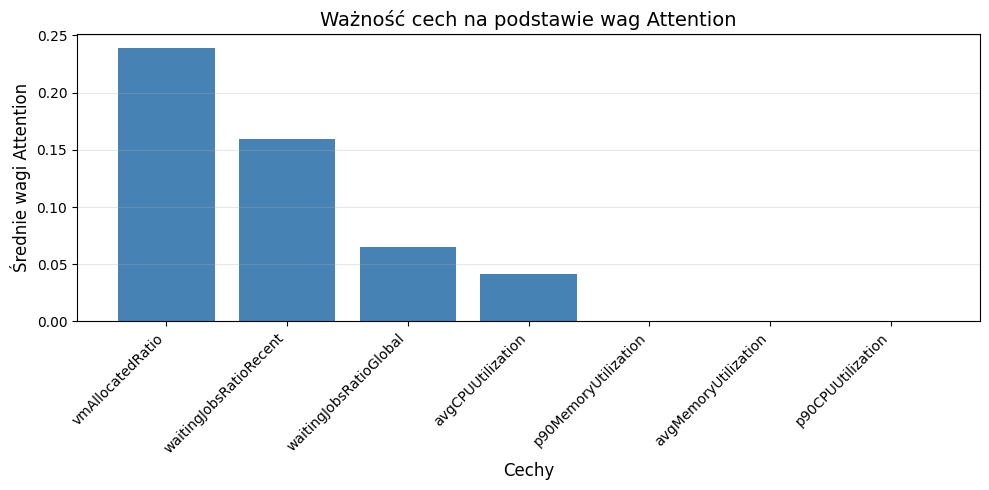


=== Ranking cech według uwagi ===
1. vmAllocatedRatio: 0.2390
2. waitingJobsRatioRecent: 0.1599
3. waitingJobsRatioGlobal: 0.0655
4. avgCPUUtilization: 0.0415
5. p90MemoryUtilization: 0.0000
6. avgMemoryUtilization: 0.0000
7. p90CPUUtilization: 0.0000
Attention visualization saved to: attention_feature_importance.png


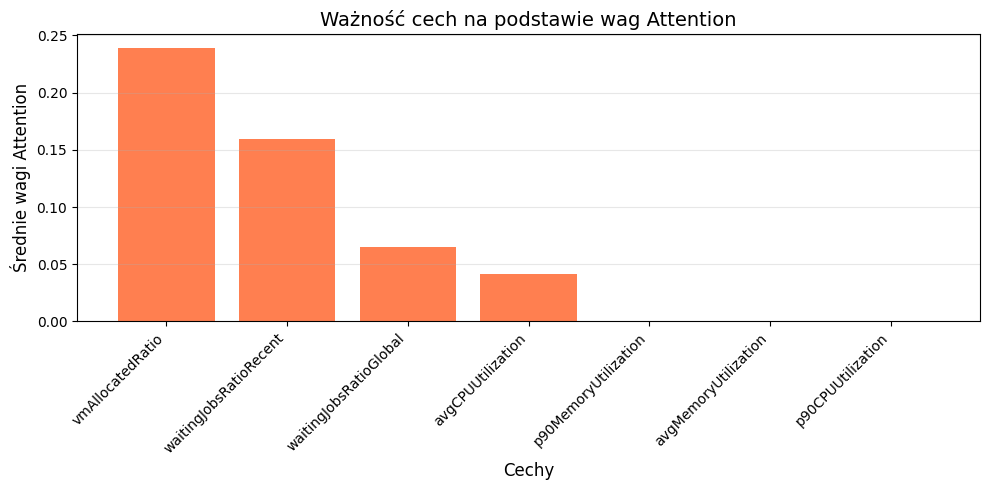


=== Ranking cech według uwagi ===
1. vmAllocatedRatio: 0.2390
2. waitingJobsRatioRecent: 0.1599
3. waitingJobsRatioGlobal: 0.0655
4. avgCPUUtilization: 0.0415
5. p90MemoryUtilization: 0.0000
6. avgMemoryUtilization: 0.0000
7. p90CPUUtilization: 0.0000

=== Wybrane cechy (top 3) ===
1. vmAllocatedRatio
2. waitingJobsRatioRecent
3. waitingJobsRatioGlobal


In [14]:
# Basic usage - will show visualization
scores, order, ranked = rank_features_by_attention_awrl(
    model, env, FEATURE_NAMES, 
    episodes=20, 
    visualize=True,
    viz_color='steelblue'
)

# Or use the full pipeline
selected = attention_selection_pipeline(
    model, env, FEATURE_NAMES,
    episodes=20,
    k_keep=3,
    visualize=True,
    viz_color='coral'  # different color
)

Attention visualization saved to: attention_feature_importance.png


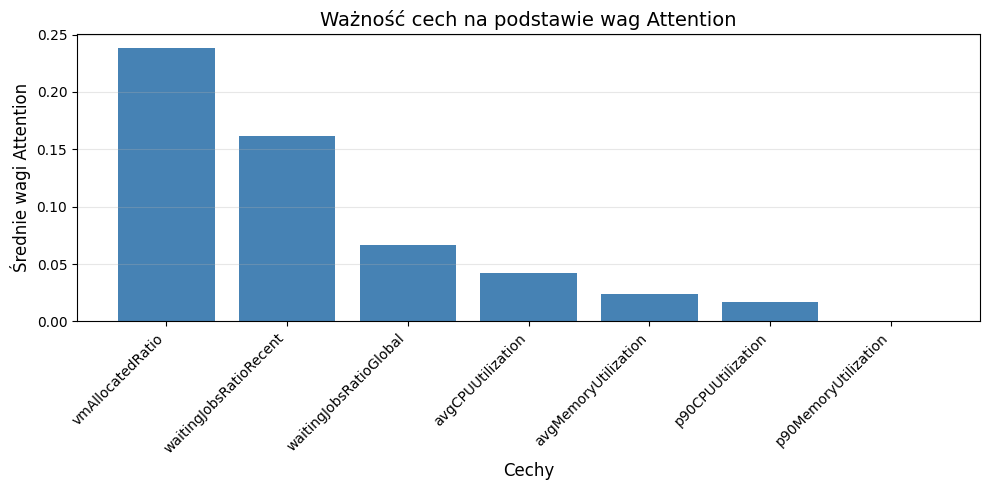


=== Ranking cech według uwagi ===
1. vmAllocatedRatio: 0.2383
2. waitingJobsRatioRecent: 0.1615
3. waitingJobsRatioGlobal: 0.0666
4. avgCPUUtilization: 0.0419
5. avgMemoryUtilization: 0.0243
6. p90CPUUtilization: 0.0173
7. p90MemoryUtilization: 0.0000

=== Wybrane cechy (top 4) ===
1. vmAllocatedRatio
2. waitingJobsRatioRecent
3. avgMemoryUtilization
4. avgCPUUtilization
Selected metrics: ['vmAllocatedRatio', 'waitingJobsRatioRecent', 'avgMemoryUtilization', 'avgCPUUtilization']
Extractor-picked indices: [0, 5, 6]
Extractor-picked names: ['vmAllocatedRatio', 'waitingJobsRatioGlobal', 'waitingJobsRatioRecent']


In [15]:
# names must match the observation order (length 7)
from utils import FEATURE_NAMES
metric_names = FEATURE_NAMES
# 1) Rank + select top-3 (Attn×|z-scored input|), and apply mask to extractor
selected = attention_selection_pipeline(
    model, env, metric_names,
    episodes=30,          # collect more steps for stabler ranks
    k_keep=4,
    use_attn_x_input=True,
    dedupe=True,          # optional redundancy pruning
    dedupe_pool=5
)
print("Selected metrics:", selected)

# 2) (Even simpler) Let the extractor decide from its rolling history
#    (make sure you've rolled the policy for a bit first)
keep_idx = select_via_extractor_mask(model, keep_top_k=3)
print("Extractor-picked indices:", keep_idx)
print("Extractor-picked names:", [metric_names[i] for i in keep_idx])


In [14]:
# If it's a deque, also check max length
fx = model.policy.features_extractor
if hasattr(fx.attn_history, 'maxlen'):
    print(f"Maximum history capacity: {fx.attn_history.maxlen}")

Maximum history capacity: 1000


### Comparing two modes of attention selection